In [2]:
"""@author: nma"""


'@author: nma'

In [1]:
import xarray as xr
import xesmf
#from HCtFlood.kara import flood_kara
#import bottleneck
import os
import numpy as np
#%%

In [2]:
os.chdir("/home/nma/HDD/vinay/archives/IOMOM5Op/")
exp_dir = '/home/nma/mom/vinay/MOM6dev/prepro/obc/'

In [3]:
uu = xr.open_mfdataset("*.ocean_uvel.nc")
vv = xr.open_mfdataset("*.ocean_vvel.nc")
grd_p = "/home/nma/mom/MOM6dev/exps/regional2/INPUT/bob_grid.nc"
grid = xr.open_dataset(grd_p)
sam_op = xr.open_dataset("/home/nma/HDD/vinay/archives/finals/20130101.ocean_sfc.nc")

In [4]:
ds = xr.merge([uu,vv])
ds_cut = ds.sel(xu_ocean=slice(65,100), yu_ocean=slice(0,28))


## southern boundary

In [19]:
south = xr.Dataset()
south['lon'] = grid['x'].isel(nyp=0)
south['lat'] = grid['y'].isel(nyp=0)


## western boundary

In [20]:
west = xr.Dataset()
west['lon'] = grid['x'].isel(nxp=0)
west['lat'] = grid['y'].isel(nxp=0)


In [21]:
regrid_south = xesmf.Regridder(ds_cut.rename({'xu_ocean': 'lon', 'yu_ocean': 'lat'}), south, 'bilinear', 
                               locstream_out=True, periodic=False, filename='regrid_south.nc')

In [22]:
regrid_west = xesmf.Regridder(ds_cut.rename({'xu_ocean': 'lon', 'yu_ocean': 'lat'}), west, 'bilinear', 
                              locstream_out=True, periodic=False, filename='regrid_west.nc')

In [24]:
u_west = regrid_west(ds_cut['u'])
v_south = regrid_south(ds_cut['v'])

/home/nma/nma/miniconda3/envs/mom/lib/python3.8/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('yu_ocean', 'xu_ocean') from data variable u as the horizontal dimensions for the regridding.
  warnings.warn(
/home/nma/nma/miniconda3/envs/mom/lib/python3.8/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('yu_ocean', 'xu_ocean') from data variable v as the horizontal dimensions for the regridding.
  warnings.warn(


%

In [33]:
drowned_u_west = u_west.ffill(dim='nyp').ffill(dim='st_ocean')

drowned_v_south = v_south.ffill(dim='nxp').ffill(dim='st_ocean')

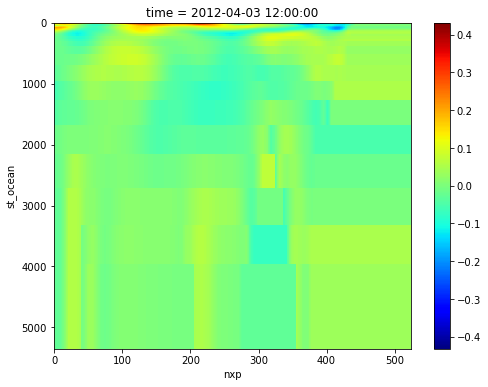

In [34]:

drowned_v_south.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

### adding dim

In [35]:
n_west_array = np.expand_dims(drowned_u_west.values,axis=3)

n_south_array = np.expand_dims(drowned_v_south.values,axis=2)

In [36]:
west_final = xr.Dataset({
    "u" : (["time","zl","yh","xq"],n_west_array),},
    coords = {"time":(["time",],drowned_u_west.time.values),
              "zl":(["zl",],drowned_u_west.st_ocean.values),
              "yh":(["yh",],drowned_u_west.lat.values),
              "xq":(["xq"],[drowned_u_west.lon.values[0]])})


south_final = xr.Dataset({
    "v" : (["time","zl","yq","xh"],n_south_array),},
    coords = {"time":(["time",],drowned_v_south.time.values),
              "zl":(["zl",],drowned_v_south.st_ocean.values),
              "yq":(["yq",],[drowned_v_south.lat.values[0]]),
              "xh":(["xh"],drowned_v_south.lon.values)})

In [38]:
west_final.to_netcdf(exp_dir+"section_west2.nc")


south_final.to_netcdf(exp_dir+"section_south2.nc")

PermissionError: [Errno 13] Permission denied: b'/home/nma/mom/vinay/MOM6dev/prepro/obc/section_west2.nc'